In [1]:
# Machine Learning Engineering HW #4
# Nicholas March
# 661848406

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.layers import Dense
from keras import optimizers
from tensorflow.python.keras.optimizers import *
import matplotlib.pyplot as plt

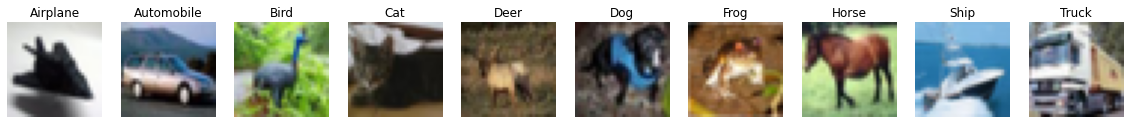

Shape of x training data: (42000, 3072)
Shape of x testing data: (18000, 3072)
Shape of y training data: (42000, 10)
Shape of y testing data: (18000, 10) 

Grid Search Run #1   Accuracy: 0.4163   Initial LR: 0.001   # Epochs: 50   1st Layer Neurons: 512
Grid Search Run #2   Accuracy: 0.3569   Initial LR: 0.001   # Epochs: 50   1st Layer Neurons: 768
Grid Search Run #3   Accuracy: 0.4137   Initial LR: 0.001   # Epochs: 100   1st Layer Neurons: 512
Grid Search Run #4   Accuracy: 0.4703   Initial LR: 0.001   # Epochs: 100   1st Layer Neurons: 768
Grid Search Run #5   Accuracy: 0.4941   Initial LR: 0.0001   # Epochs: 50   1st Layer Neurons: 512
Grid Search Run #6   Accuracy: 0.4982   Initial LR: 0.0001   # Epochs: 50   1st Layer Neurons: 768
Grid Search Run #7   Accuracy: 0.5141   Initial LR: 0.0001   # Epochs: 100   1st Layer Neurons: 512
Grid Search Run #8   Accuracy: 0.5056   Initial LR: 0.0001   # Epochs: 100   1st Layer Neurons: 768

GridSearch CV Optimal Results
Accuracy: 0.514111101

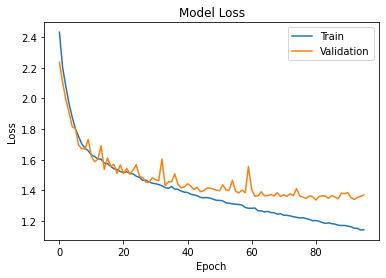

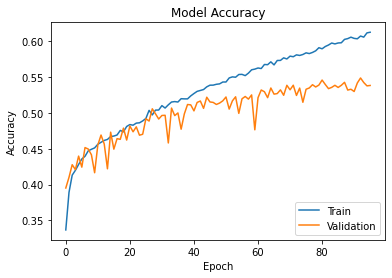

In [3]:
# Problem 1

# Input data and combine together
a, b = keras.datasets.cifar10.load_data()
x_data = np.concatenate((a[0],b[0]))
y_data = np.concatenate((a[1],b[1]))

# Plot CIFAR10 data
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
unique_classes = np.unique(y_data)
fig, axes = plt.subplots(1, len(unique_classes), figsize=(20, 2))
for ax, cls in zip(axes, unique_classes):
    idx = np.where(y_data == cls)[0][0]
    ax.imshow(x_data[idx])
    ax.set_title(class_names[cls])
    ax.axis('off')
plt.show()

# Split data into training and testing arrays
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

# Convert the target data into one-hot encoded vectors
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Normalize and reshape data
x_train = x_train.reshape(42000, 3072) / 255.0
x_test = x_test.reshape(18000, 3072) / 255.0

# Display data shapes
print("Shape of x training data:",x_train.shape)
print("Shape of x testing data:",x_test.shape)
print("Shape of y training data:",y_train.shape)
print("Shape of y testing data:",y_test.shape,"\n")

# Implement early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0)

# Define fixed parameters
l2_reg = 0.0005
drop_out = 0.2
batchnum = 25
j = 0

# Define paramter space
lr_param = [0.001, 0.0001] # Starting learning rate
epoch_param = [50, 100] # Epoch number
neuron_param = [512, 768] # Number of neurons in first hidden layer
best_results = [0, 0, 0, 0]

# Conduct grid search
for lr in lr_param:
    for epochnum in epoch_param:
        for neurons in neuron_param:
            j += 1
            model = Sequential()
            model.add(Dense(units=neurons, activation='relu', input_shape=(3072,), kernel_regularizer=l2(l2_reg)))
            model.add(BatchNormalization())
            model.add(Dropout(drop_out))
            model.add(Dense(units=neurons//2, activation='relu', kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(drop_out))
            model.add(Dense(units=10, activation='softmax'))
            reduce_lr = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=10000,
                                                           decay_rate=0.90,
                                                           staircase=False)
            opt = optimizers.Adam(learning_rate=reduce_lr)
            model.compile(optimizer=opt,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
            model.fit(x_train, y_train, epochs=epochnum, batch_size=batchnum,
            validation_split=0.3, callbacks=[early_stopping], verbose=0)
            test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
            if test_acc > best_results[0]:
                best_results = [test_acc, lr, epochnum, neurons]
            print("Grid Search Run #"+str(j),"  Accuracy:",round(test_acc,4), "  Initial LR:",lr,
                  "  # Epochs:",epochnum,"  1st Layer Neurons:",neurons)
            del model

# Output results of GridSearch CV
print("\nGridSearch CV Optimal Results")
print("Accuracy:",best_results[0])
print("Initial Learning Rate:",best_results[1])
print("Number of Epochs:",best_results[2])
print("1st Layer Neuron Number:",best_results[3])

# Construct model with optimized paramters
model = Sequential()
model.add(Dense(units=best_results[3], activation='relu', input_shape=(3072,), kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(drop_out))
model.add(Dense(units=best_results[3]//2, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(Dropout(drop_out))
model.add(Dense(units=10, activation='softmax'))
reduce_lr = tf.keras.optimizers.schedules.ExponentialDecay(best_results[1], decay_steps=10000,
                                                           decay_rate=0.90,
                                                           staircase=False)
opt = optimizers.Adam(learning_rate=reduce_lr)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    epochs=best_results[2], batch_size=batchnum, 
                    validation_split=0.3, callbacks=[early_stopping], verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Output model accuracy
print("\nOptimized Model Accuracy:",round(test_acc,4))

# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

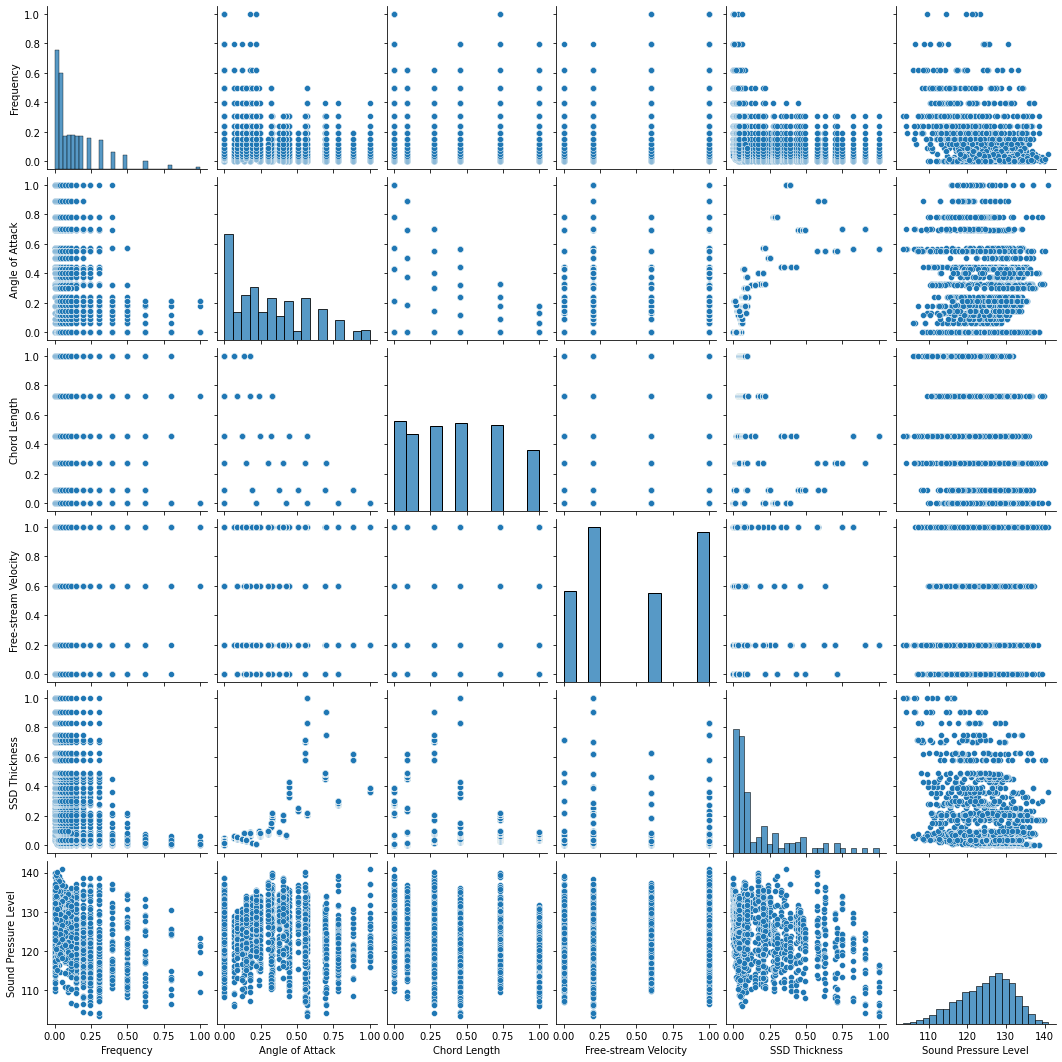

Feature Training Data Shape: (1052, 5)
Feature Testing Data Shape: (451, 5)
Target Training Data Shape: (1052,)
Target Testing Data Shape: (451,) 

15/15 [==============================] - 0s 3ms/step

Learning Rate: 0.001
Number of Epochs: 500
Batch Size: 10

Coefficient of Determination: 0.9575


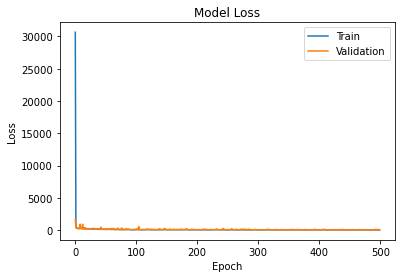

Predicted Sound Level: 130.8663 dB	Actual Sound Level: 130.787 dB
Predicted Sound Level: 119.1387 dB	Actual Sound Level: 119.541 dB
Predicted Sound Level: 111.3858 dB	Actual Sound Level: 110.317 dB
Predicted Sound Level: 117.228 dB	Actual Sound Level: 117.396 dB
Predicted Sound Level: 126.9858 dB	Actual Sound Level: 127.625 dB


In [4]:
# Problem 2
# Input data and specify feature and target labels
f = open("airfoil_self_noise.dat")
features = []
target = []
for line in f:
    features.append(line.split())
    target.append(features[-1].pop())
feature_lbls = ["Frequency","Angle of Attack","Chord Length",
                "Free-stream Velocity", "SSD Thickness"]
target_lbl = "Sound Pressure Level"

# Normalize data
features = np.array(features).astype(float)
target = np.array(target).astype(float)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)

# Visualize data via pair plot
import pandas as pd
pairplot_data = pd.DataFrame(scaled_features, columns=feature_lbls)
pairplot_data[target_lbl] = target
import seaborn as sns
sns.pairplot(pairplot_data)
plt.show()

# Split data and print array shapes
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.3, random_state=0)
print("Feature Training Data Shape:",x_train.shape)
print("Feature Testing Data Shape:",x_test.shape)
print("Target Training Data Shape:",y_train.shape)
print("Target Testing Data Shape:",y_test.shape,"\n")

# Define Keras model
model = Sequential()
model.add(Dense(1024,input_dim=5,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1))

# Compile the Keras model
lr = 0.001 # Learning rate
opt = optimizers.Adam(learning_rate=lr)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
model.compile(loss=mse, optimizer=opt)

# Fit Keras model and make prediction
epc = 500 # Number of epochs 
bs = 10 # Batch size
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epc,batch_size=bs, verbose=0)
predictions = model.predict(x_test)
loss = model.evaluate(x_test, y_test, verbose=0)

# Print model properties
print("\nLearning Rate:",lr)
print("Number of Epochs:",epc)
print("Batch Size:",bs)

# Calculate coefficient of determination
from sklearn.metrics import r2_score
r2 = round(r2_score(y_test, predictions),4)
print("\nCoefficient of Determination:",r2)

# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Output some predictions:
for i in range(5):
    print("Predicted Sound Level:",round(float(predictions[i]),4),"dB\tActual Sound Level:",round(float(y_test[i]),5),"dB")

I apologize for the lateness of my submission, my gridsearch method ended up taking approximately 8 hours to run and due to some syntax and formatting errors I had to run it multiple times and so it took me way longer to get an acceptable output than I expected. Sorry again.